In [1]:
import numpy as np
import argparse

import torch
import matplotlib.pyplot as plt

from Trainer.maskgit import MaskGIT

In [2]:
CONDITIONALISE_DIM=2

In [4]:
class Args(argparse.Namespace):
    patch_size=7
    hidden_dim=4
    codebook_path="/scratches/kyuban/foo22/Data/Physics_Simulation/intermediate_data/codebook/four_compression/bp_64/codebook.npy"
    load_vqgan=False
    data_folder="/scratches/kyuban/foo22/Data/Physics_Simulation/intermediate_data/codebook/four_compression/bp_64/codebook_indices/"                     
    # vit_folder="/scratches/kyuban/foo22/Data/Physics_Simulation/intermediate_data/maskgit_2d_positive/epoch_290.pth"                     
    vit_folder="/scratches/kyuban/foo22/Data/Physics_Simulation/intermediate_data/maskgit_2d_full/current.pth"
    codebook_size=1000
    vqgan_folder="./pretrained_maskgit/VQGAN/"
    temporal=False
    conditionalise_dim=CONDITIONALISE_DIM
    writer_log=""
    data = "gs"
    mask_value = 1000                                                            # Value of the masked token
    img_size = 256                                                               # Size of the image
    path_size = img_size // 16                                                   # Number of vizual token
    seed = 1                                                                     # Seed for reproducibility
    channel = 3                                                                  # Number of input channel
    num_workers = 4                                                              # Number of workers
    iter = 1_500_000                                                             # 750_000 at 256*256 + 750_000 at 512*512
    global_epoch = 380                                                           # 300 epoch w/ bsize 512 + 80 epoch with bsize 128
    lr = 1e-4                                                                    # Learning rate 
    drop_label = 0.1                                                             # Drop out label for cfg
    resume = True                                                                # Set to True for loading model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        # Device
    print(device)
    debug = True                                                                 # Load only the model (not the dataloader)
    test_only = False                                                            # Dont launch the testing
    is_master = True                                                             # Master machine 
    is_multi_gpus = False  
    bsize=1                                                      # set to False for colab demo
args = Args()
maskgit = MaskGIT(args)

cuda
Acquired codebook size: 1000
load ckpt from: /scratches/kyuban/foo22/Data/Physics_Simulation/intermediate_data/maskgit_2d_full/current.pth
Size of model vit: 170.759M
Number of params:  170815274


In [5]:
def plot(gc):
    img = gc % 8
    img[gc == 1000] = 8
    img[gc==1001] = 9
    if CONDITIONALISE_DIM == -1:
        img = img.reshape(7, 7, 7)
        for i in range(7):
            plt.subplot(1, 7, i+1)
            plt.imshow(img[i], cmap='tab10', vmin=0, vmax=9)
            plt.axis('off')
    else:
        img = img.reshape(7, 7)
        plt.imshow(img, cmap='tab10', vmin=0, vmax=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_with_mask(gc, mask):
    # print(mask.shape, gc.shape)
    img = gc % 8
    img[gc == 1000] = 8
    img[gc==1001] = 9
    img[np.array(mask, dtype=bool)] = 8
    if CONDITIONALISE_DIM == -1:
        img = img.reshape(7, 7, 7)
        for i in range(7):
            plt.subplot(1, 7, i+1)
            plt.imshow(img[i], cmap='tab10', vmin=0, vmax=9)
            plt.axis('off')
    else:
        img = img.reshape(7, 7)
        plt.imshow(img, cmap='tab10', vmin=0, vmax=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Show Dataset Example

In [6]:
train_data, _ = maskgit.get_data(conditionalise_dim=CONDITIONALISE_DIM, temporal=False)

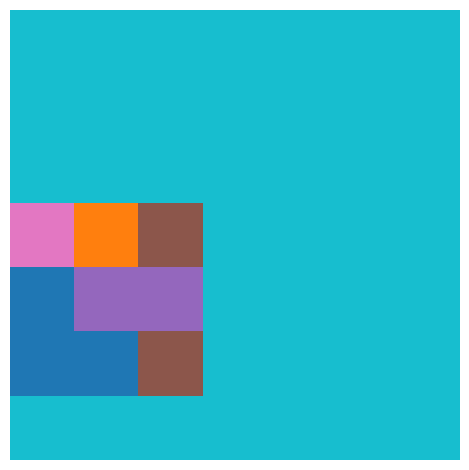

[1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001
 1001 1001 1001 1001 1001 1001 1001  967  967  967 1001 1001 1001 1001
  334  587  998 1001 1001 1001 1001  587  587  998 1001 1001 1001 1001
 1001 1001 1001 1001 1001 1001 1001]


In [7]:
plot(train_data.dataset[2][0])
print(train_data.dataset[0][0].flatten())

# Generate an Unconditional Sample

In [22]:
sm_temp = 1.0          # Softmax Temperature
r_temp = 7             # Gumbel Temperature
w = 0                  # Classifier Free Guidance
randomize = "linear"   # Noise scheduler
step = 32              # Number of step
sched_mode = "cosine"  # Mode of the scheduler

gen_sample, gen_code, l_mask = maskgit.sample(nb_sample=1, labels=None, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)

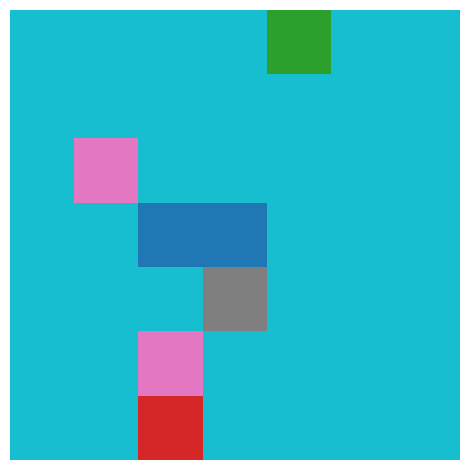

tensor([1001, 1001, 1001, 1001,  706, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
        1001, 1001, 1001,  142, 1001, 1001, 1001, 1001, 1001, 1001, 1001,  192,
         912, 1001, 1001, 1001, 1001, 1001, 1001,  911, 1001, 1001, 1001, 1001,
        1001,  462, 1001, 1001, 1001, 1001, 1001, 1001,  403, 1001, 1001, 1001,
        1001], device='cuda:0')


In [23]:
plot(gen_sample.detach().cpu().numpy())
print(gen_sample.flatten())

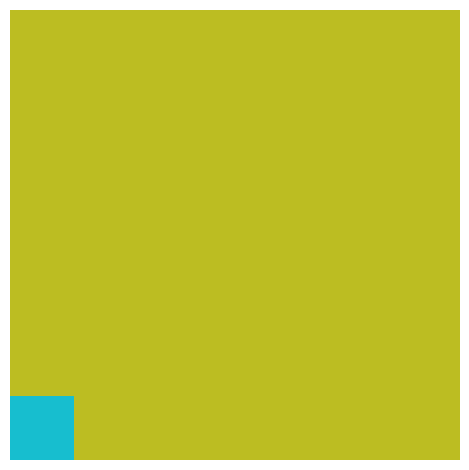

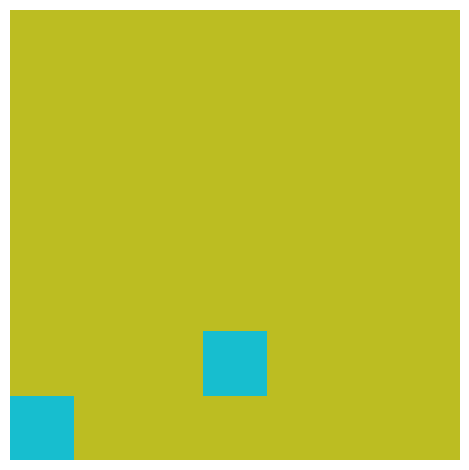

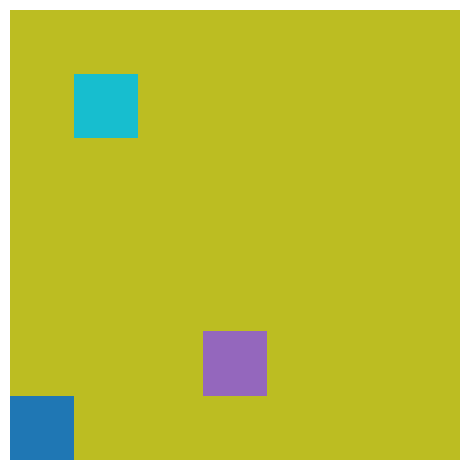

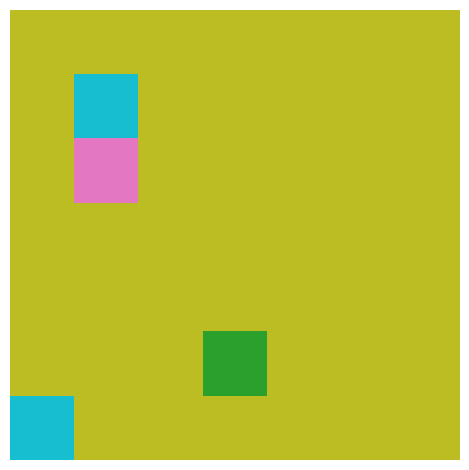

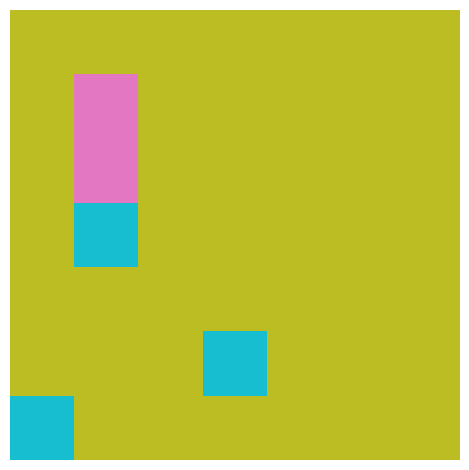

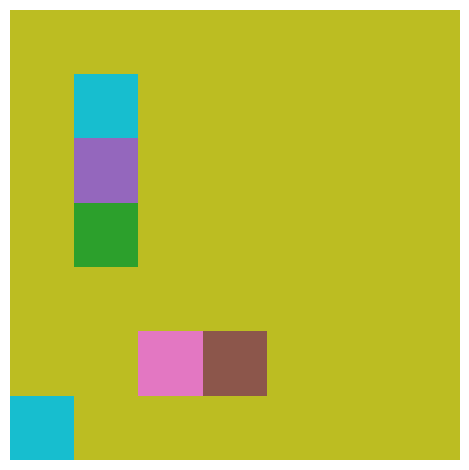

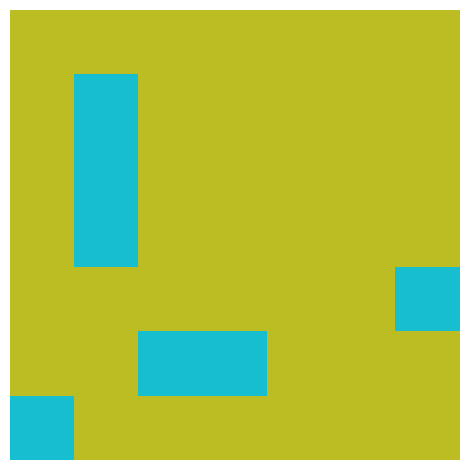

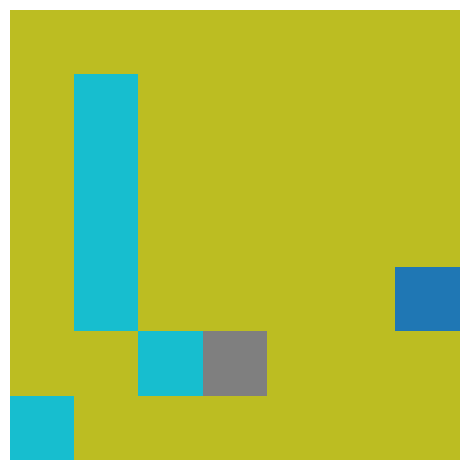

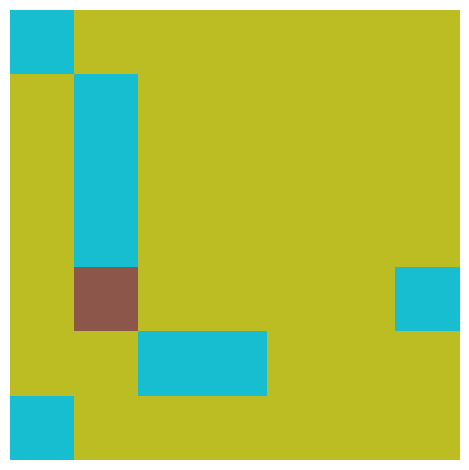

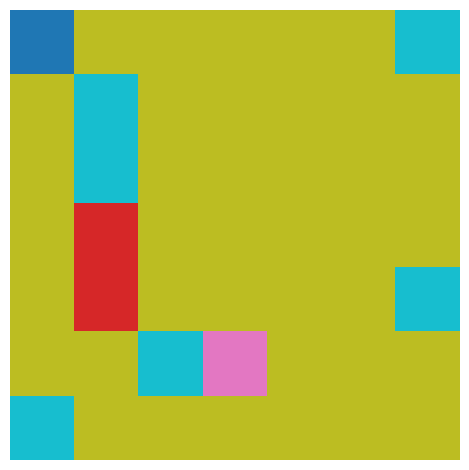

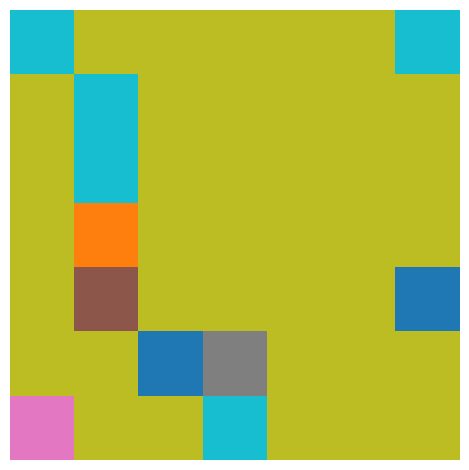

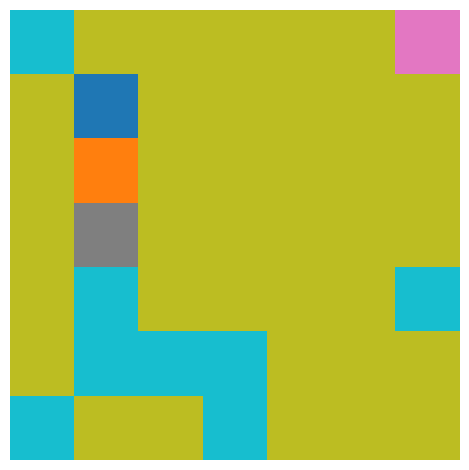

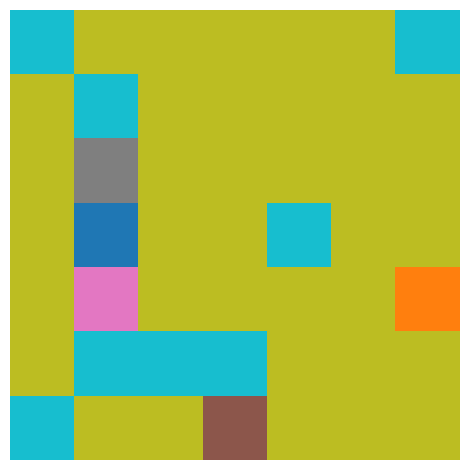

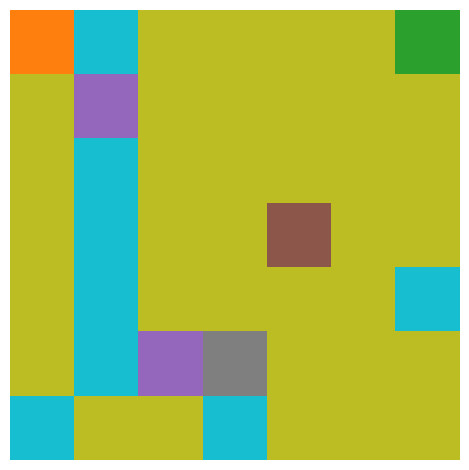

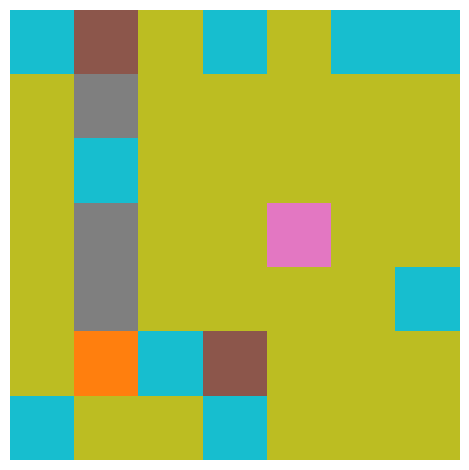

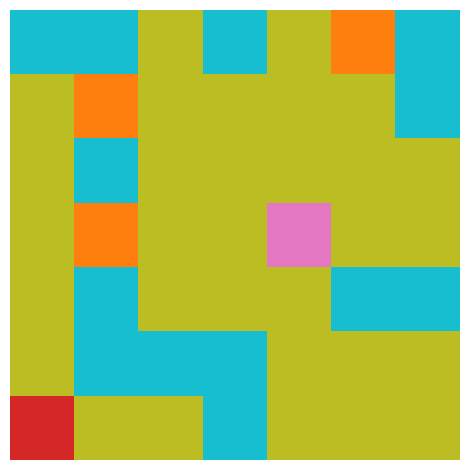

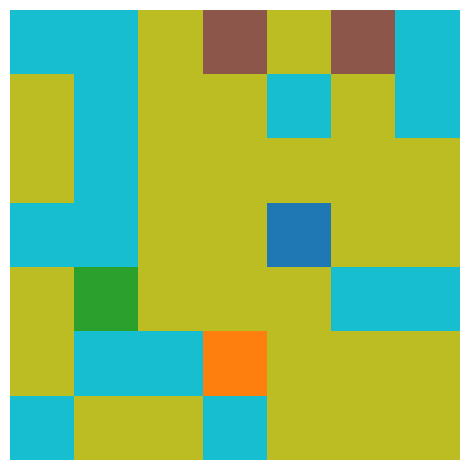

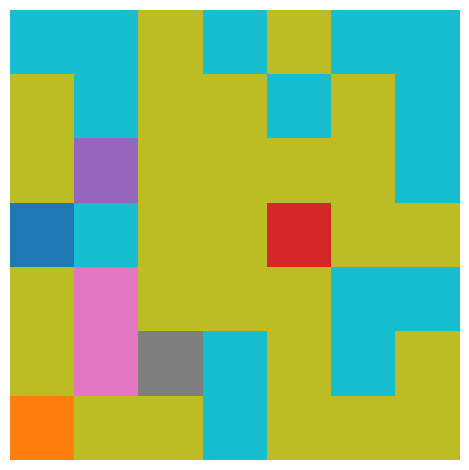

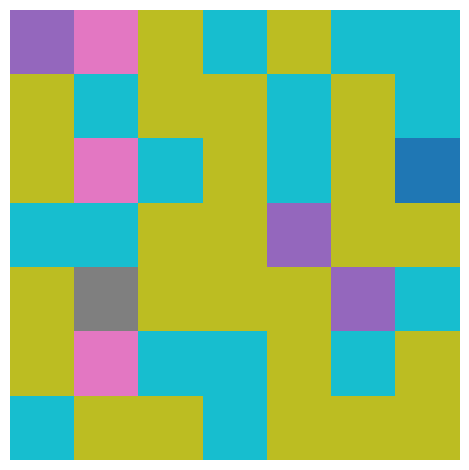

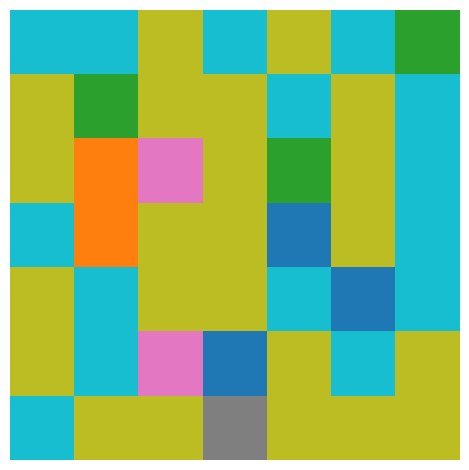

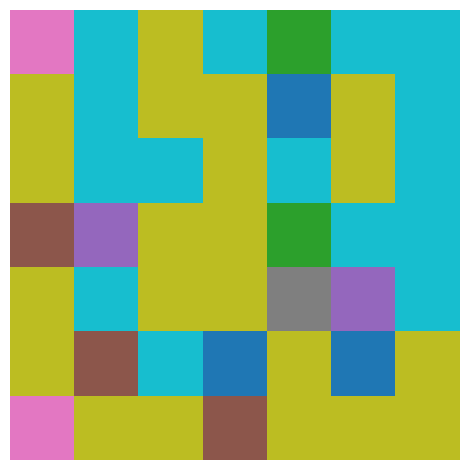

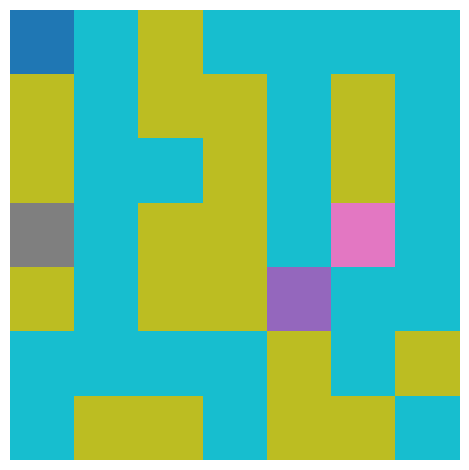

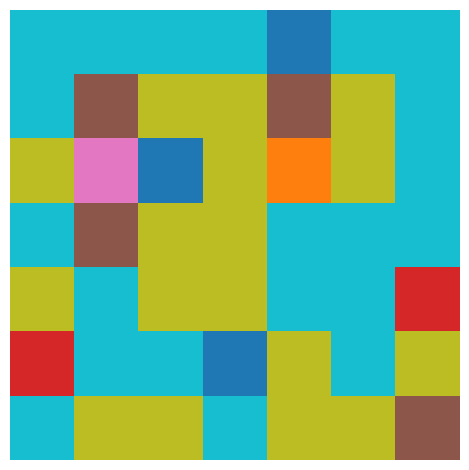

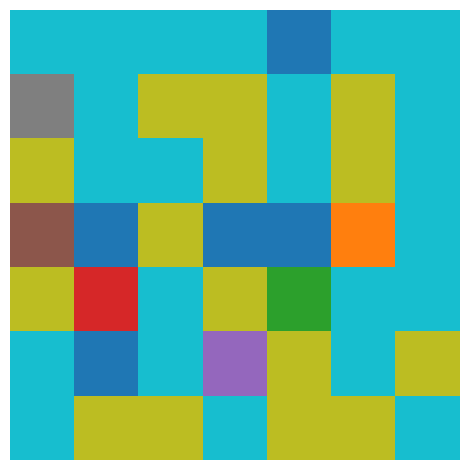

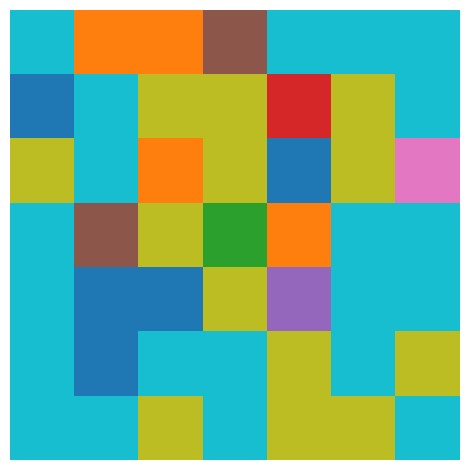

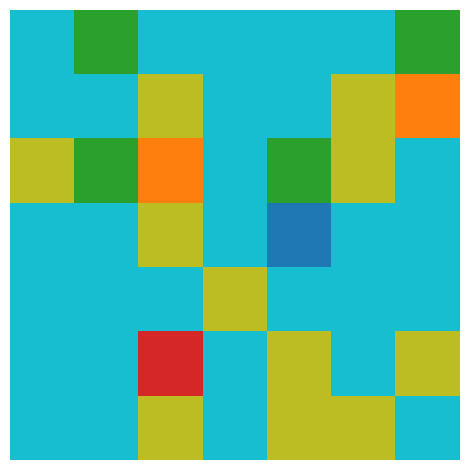

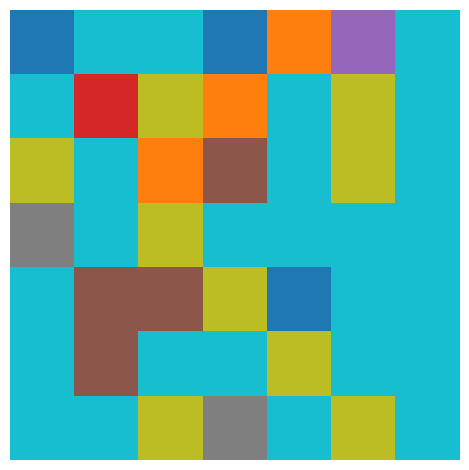

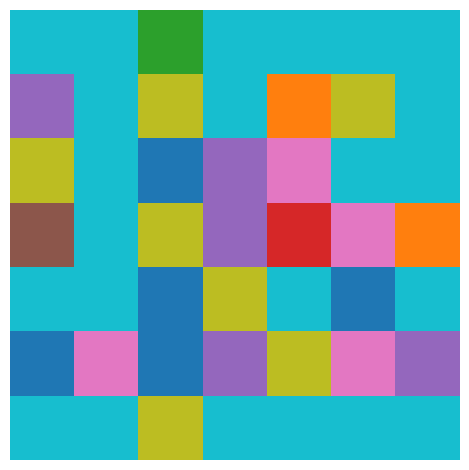

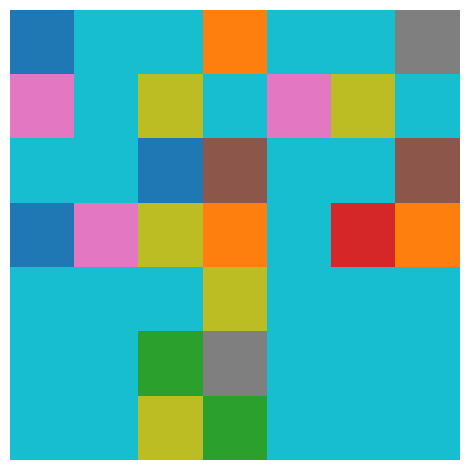

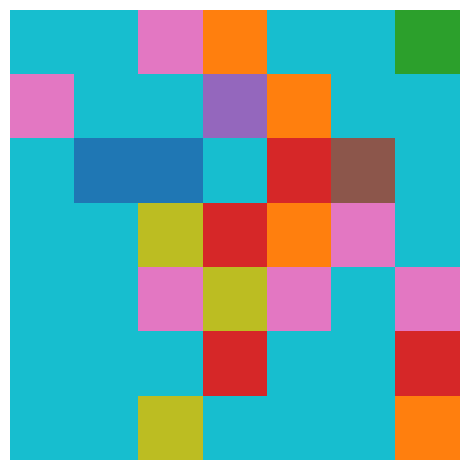

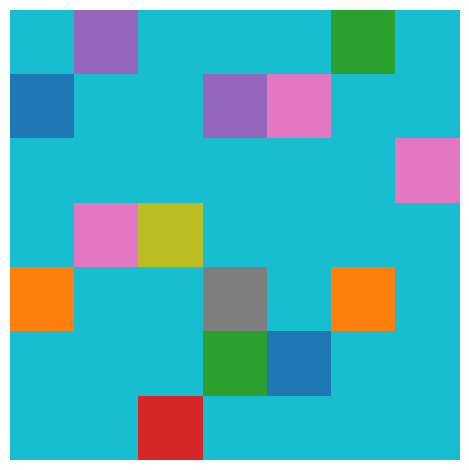

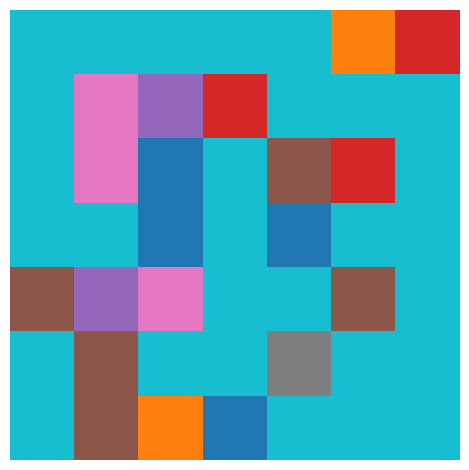

In [24]:
for i in range(step):
    plot_with_mask(gen_code[i][0].cpu().numpy(), l_mask[i][0].cpu().numpy())

## Generate a Sample From Partial Data

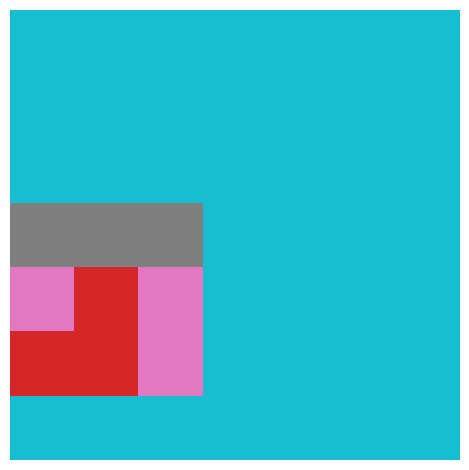

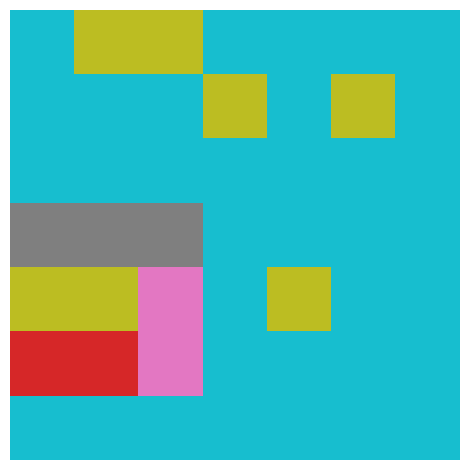

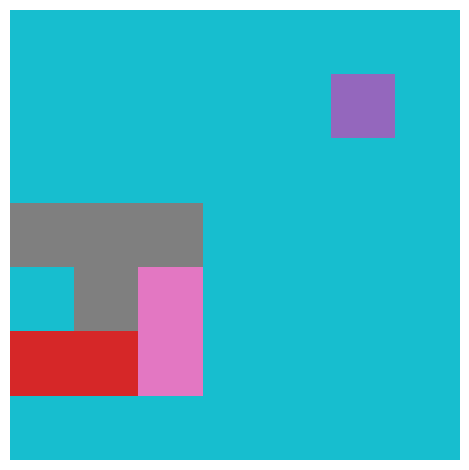

In [35]:
init_code = torch.tensor(train_data.dataset[0][0])
init_code = init_code.to('cuda')
shape = (7, 7, 7) if CONDITIONALISE_DIM == -1 else (7, 7)
init_code = init_code.view(1, *shape)

mask_ratio = 0.1

plot(init_code.detach().cpu().numpy())  
if False:
    init_code[:, :,:,3:] = 1000
elif True:
    msk = torch.rand(1, *shape) < mask_ratio
    init_code[msk] = 1000
init_code = init_code.view(1,-1)

plot(init_code.detach().cpu().numpy())

gen_sample, gen_code, l_mask = maskgit.sample(init_code = init_code, nb_sample=1, labels=None, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)

plot(gen_sample.detach().cpu().numpy())
# plot(gen_code[25][0].cpu().numpy())

## Show Positional Encoding

In [27]:
pos_enc = maskgit.vit.pos_emb.view(*shape, 4).detach().cpu().numpy()

(7, 7, 4)
(1, 7, 7, 4)
(1, 7, 7, 4)
(1, 7, 7, 4)


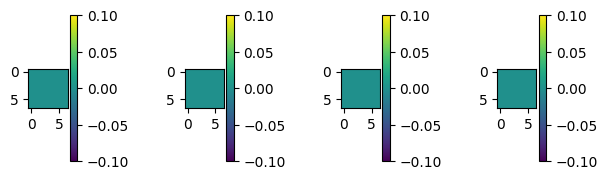

In [28]:
z_dim = 7 if CONDITIONALISE_DIM == -1 else 1
for i in range(z_dim):
    for j in range(4):
        plt.subplot(z_dim, 4, 4*i+j+1)
        print(pos_enc.shape)
        pos_enc = pos_enc.reshape(z_dim, 7, -1, 4)
        plt.imshow(pos_enc[i, ..., j], cmap='viridis')
        plt.colorbar()
        # plt.axis('off')
plt.tight_layout()